In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())

from testsuite.utilities import Pareto_split
from testsuite.analysis import load_all #, plot_all_pareto_2d, PLOT_STYLE, plot_measure
from problem_setup import func, y, weighting, n_obj, n_dim

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
names = ['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgo_ei', 'SmsEgo_$\\mu$', 'lhs']
true_names = ['MPoI', 'ParEGO', 'SAF: ei', 'SAF: $\mu$', 'SMS-EGO: ei', 'SMS-EGO: $\mu$', 'LHS']
D_names = {a:b for a, b in zip(names, true_names)}

In [3]:
# establish up data paths
try: 
    get_ipython().__class__.__name__
    script_dir = os.path.dirname(os.path.realpath(__file__))
except:
     script_dir = './'
results_dir = os.path.join(script_dir, "log_data/")
result_dirs = sorted(os.listdir(results_dir))

pkl_dir = os.path.join(script_dir, "pkl_data/")
pkl_filename = pkl_dir+'results_new.pkl'
if not os.path.isdir(pkl_dir):
    os.makedirs(pkl_dir)

In [4]:
try:
    with open(pkl_filename,'rb') as infile:
        results = pickle.load(infile)
    print("results loaded from ", pkl_dir)
except FileNotFoundError:
    print("Failed to find results file in {}".format(pkl_filename))
    print("Results processing should be done first by running results_processing.py")
    
# assert len(results.keys()) == 7, "Not all optimisers present"
for key, value in results.items():
    print(key, " found")
    assert len(value['hypervolume']) == 31, \
    "not all hypervolumes for 31 repeats present for {}. Instead {} found.".format(key, len(value['hypervolume']))
    assert len(value['igd+']) == 31, \
    "not all igd+ for 31 repeats present for {}. Instead {} found.".format(key, len(value['hypervolume']))
    old_name = value['name']
    new_name = D_names[old_name]
    results[key]['name'] = new_name 
    print("name changed {} \t--->\t{}".format(old_name, new_name))

results loaded from  ./pkl_data/
Mpoi  found
name changed Mpoi 	--->	MPoI
ParEgo  found
name changed ParEgo 	--->	ParEGO
Saf_ei  found
name changed Saf_ei 	--->	SAF: ei
Saf_$\mu$  found
name changed Saf_$\mu$ 	--->	SAF: $\mu$
SmsEgo_ei  found
name changed SmsEgo_ei 	--->	SMS-EGO: ei
SmsEgo_$\mu$  found
name changed SmsEgo_$\mu$ 	--->	SMS-EGO: $\mu$
lhs  found
name changed lhs 	--->	LHS


In [5]:
results['Mpoi']['hypervolume'][0, -1]


29.250189514889886

In [30]:
matplotlib.rcParams['mathtext.fontset'] = 'stix';
matplotlib.rcParams['font.family'] = 'STIXGeneral';
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.rcParams['legend.fontsize'] = 11

markers = ["o", "d", "^", "P", "X", "v", "*"]
cmap = matplotlib.cm.Dark2
# colors = cmap(np.linspace(0, 1, len(result_dirs)+1))
colors = cmap([0, 1, 2, 3, 4, 5, 6])

In [23]:
#fig = plt.figure(figsize=[10, 4])
#if n_obj > 3:
#    print("cannot plot more objectives than 3")
#else:
#    if n_obj == 2:
#        ax1=fig.add_subplot(1,2,1)
#        ax2=fig.add_subplot(1,2,2)
#    elif n_obj == 3:
#        ax1=fig.add_subplot(1,2,1, projection="3d")
#        ax2=fig.add_subplot(1,2,2, projection="3d")
#    ax1.scatter(*y.T)
#    ax2.scatter(*(y/weighting).T, c="C1")
#    plt.suptitle(func.__name__)
#    ax1.set_title("unscaled")
#    ax2.set_title("scaled with axis maxima: {}".format((y/weighting).max(axis=0).round(3)))
#    
#    plt.show(block=True)

In [24]:
def plot_measure(results, measure, axis=None, plot_individuals=False, 
                     color="C0", marker=None): 
    if axis is None: 
        fig = plt.figure(figsize=[12, 8]) 
        axis = fig.gca() 
        
    label = results['name']
 
    mes = results[measure] 
    if plot_individuals: 
        for i, hv in enumerate(mes): 
            # plot idividual results 
            n_inital = results["n_initial"][i] 
            n_total = results["n_evaluations"][i] 
            bo_steps = range(n_inital, n_total + 1) 
            axis.plot(bo_steps, hv, linestyle=":", c=color, alpha=0.4) 
 
    # trim mes to min length so as to compute mean 
    array_mes = np.array([hv[:min([len(hv) for hv in mes])] for hv in mes]) 
    n_inital = 10
    bo_steps = range(mes.shape[1]) 
    
    # plot median and iqr
    axis.plot(bo_steps, np.median(array_mes, axis=0), linestyle="-", c=color, 
              alpha=1., label=label, marker = marker, markevery=10, linewidth=1) 
    lower_qa = np.array([np.quantile(i, 0.25) for i in np.array(array_mes).T]) 
    upper_qa = np.array([np.quantile(i, 0.75) for i in np.array(array_mes).T]) 
    axis.fill_between(bo_steps, 
                      lower_qa, 
                      upper_qa, 
                      color=color, alpha=0.2) 
 
    axis.set_xlim([10, 150])
    if axis is None: 
        return fig 

def save_fig(fig, name=None):
    figname_stub = script_dir.split('/')[-1]
    if name is None:
        filename = figname_stub+"_"+fig.get_title()
    else:
        filename = figname_stub+"_"+name
    
    savedirs = [os.path.join(script_dir, "figures/"),
                "/home/finley/phd/papers/SAF-driven-EMO/figures/"]
    for d in savedirs:
        fig.savefig(os.path.join(d, filename+".png"), dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait', pad_inches=0.12)
        fig.savefig(os.path.join(d, filename+".pdf"), dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait', pad_inches=0.12)

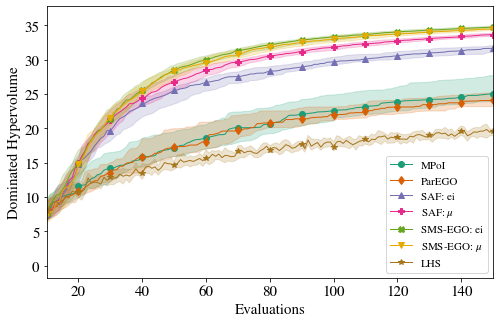

In [31]:
fig_hv = plt.figure(figsize=[8, 5])
ax_hv = fig_hv.gca()
for result, color, marker in zip(results.values(), colors, markers):
    plot_measure(result, measure="hypervolume", axis=ax_hv, plot_individuals=False, color=color, marker=marker)
ax_hv.set_xlabel("Evaluations")
ax_hv.set_ylabel("Dominated Hypervolume")
ax_hv.legend()
save_fig(fig_hv, "hv_plot")

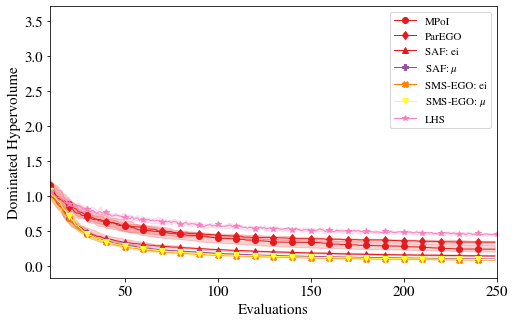

In [26]:
fig_igd = plt.figure(figsize=[8, 5])
ax_igd = fig_igd.gca()
for result, color, marker,in zip(results.values(), colors, markers):
    plot_measure(result, measure="igd+", axis=ax_igd, plot_individuals=False, color=color, marker=marker)
ax_igd.set_xlim([10, 250])
ax_igd.set_xlabel("Evaluations")
ax_igd.set_ylabel("Dominated Hypervolume")
ax_igd.legend()

save_fig(fig_igd, "igd_plot")


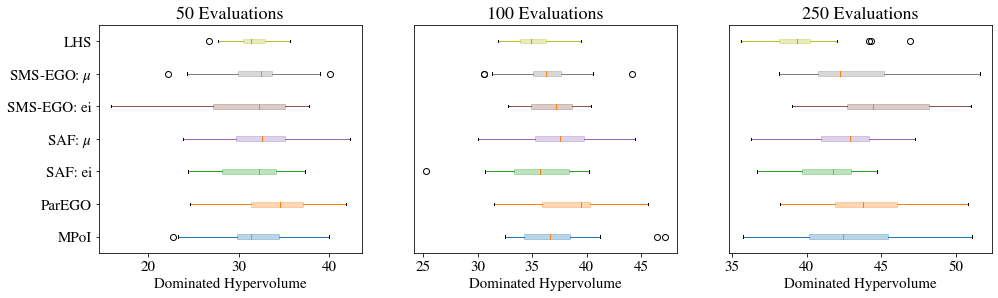

In [133]:
fig_hv_box = plt.figure(figsize=[16, 5])
fig_hv_box.tight_layout()
ax_hv_050 = fig_hv_box.add_subplot(1,3,1)
ax_hv_100 = fig_hv_box.add_subplot(1,3,2)
ax_hv_250 = fig_hv_box.add_subplot(1,3,3)
ax_hv_100.get_yaxis().set_visible(False)
ax_hv_250.get_yaxis().set_visible(False)
for i, result, color, marker,in zip(range(len(results)), results.values(), colors, markers):
    boxprops= {'color':color, 'facecolor':color, 'alpha':0.3}
    whiskerprops= {'color':color}
    meanprops = {"marker": marker, 'markerfacecolor': color, 'markeredgecolor': color}
    ax_hv_050.boxplot([hpv[50] for hpv in result["hypervolume"]], positions = [i], labels=[result["name"]], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, showmeans=False, vert=False)
    ax_hv_100.boxplot([hpv[100] for hpv in result["hypervolume"]], positions = [i], labels=[result["name"]], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, showmeans=False, vert=False)
    ax_hv_250.boxplot([hpv[-1] for hpv in result["hypervolume"]], positions = [i], labels=[result["name"]], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, showmeans=False, vert=False)

ax_hv_050.set_xlabel('Dominated Hypervolume')
ax_hv_050.set_title('50 Evaluations')
ax_hv_100.set_xlabel('Dominated Hypervolume')
ax_hv_100.set_title('100 Evaluations')
ax_hv_250.set_xlabel('Dominated Hypervolume')
ax_hv_250.set_title('250 Evaluations')

save_fig(fig_hv_box, "hv_boxplot")

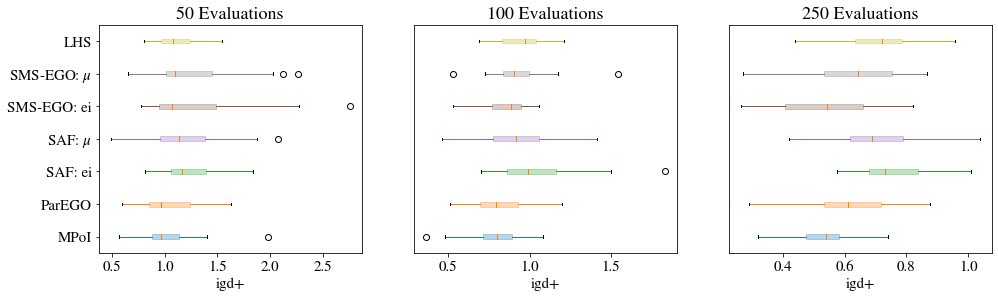

In [134]:
fig_igd_box = plt.figure(figsize=[16, 5])
fig_igd_box.tight_layout()
ax_igd_050 = fig_igd_box.add_subplot(1,3,1)
ax_igd_100 = fig_igd_box.add_subplot(1,3,2)
ax_igd_250 = fig_igd_box.add_subplot(1,3,3)
ax_igd_100.get_yaxis().set_visible(False)
ax_igd_250.get_yaxis().set_visible(False)
for i, result, color, marker,in zip(range(len(results)), results.values(), colors, markers):
    boxprops= {'color':color, 'facecolor':color, 'alpha':0.3}
    whiskerprops= {'color':color}
    meanprops = {"marker": marker, 'markerfacecolor': color, 'markeredgecolor': color}
    ax_igd_050.boxplot([hpv[50] for hpv in result["igd+"]], positions = [i], labels=[result["name"]], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, showmeans=False, vert=False)
    ax_igd_100.boxplot([hpv[100] for hpv in result["igd+"]], positions = [i], labels=[result["name"]], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, showmeans=False, vert=False)
    ax_igd_250.boxplot([hpv[-1] for hpv in result["igd+"]], positions = [i], labels=[result["name"]], patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, showmeans=False, vert=False)

ax_igd_050.set_xlabel('igd+')
ax_igd_050.set_title('50 Evaluations')
ax_igd_100.set_xlabel('igd+')
ax_igd_100.set_title('100 Evaluations')
ax_igd_250.set_xlabel('igd+')
ax_igd_250.set_title('250 Evaluations')

save_fig(fig_igd_box, "igd_boxplot")